<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Xareny González,  Estefanía Meza, Alejandra Rico

**Fecha:** 14 de octubre del 2021.

**Expediente** : 720811, 729930, 720838.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: [Link con el enlace del repositorio del creador del proyecto](https://github.com/Xarenyglp/ProyectoM1_GonzalezX_MezaE_RicoA)

# Proyecto TEMA 1

## 1.1 Análisis de servicio a cliente

A lo largo de este análisis buscamos brindar un reporte de las métricas que maneja la empresa Tramites APF la cual se dedica a brindar servicios de gestion de Visas, pasaportes y Global Entry. Al finalizar este análisis la empresa podrá tener un panorama más claro de la eficiencia de sus trabajadores y asi lograr llevar a cabo los ajustes necesarios para que de esta manera mejore su servicio a cliente.

## 1.2 Objetivos

### Objetivo General

Evaluar de que manera y el tiempo que le toma a los trabajadores realizar cada una de sus actividades analizando metricas previamente proporcionadas por la empresa para que de esta manera ellos puedan optimizar sus recursos

### Objetivos Específicos

- Estimar tiempos de respuesta totales según la categoría de tipo de trámite.
- Identificar que trámites son los que se llevan a cabo en menor tiempo de acuerdo a cada trabajador
- Estimar el tiempo invertido en atención al cliente o tiempo invertido por trabajador

## 1.3 Definición del problema

> Tramites APF es una empresa dedicada a la gestión de trámites, por medio de ellos puedes llevar a cabo tu trámite de Visa, pasaporte o Global Entry de inicio a fin sin necesidad de invertir tanto tiempo en estos procesos los cuales resultan ser tediosos y muchas veces confusos. En el último año (durante la pandemia) Tramites APF creció de una manera exponencial. En diciembre 2019 sus clientes por mes eran al rededor de 300 y para finales del 2020 ya eran aproximadamente 2000. De esta manera se han visto en la obligación de mejorar sus procesos para lograr brindar el mejor servicio al cliente ya que es uno de los motivos por los cuales las personas acuden a ellos.
El plan es claramente continuar creciendo por lo que buscamos ofrecerle a la empresa estimaciones que la apoyen en la toma de decisiones.

## 1.4 Nodos y variables que se decidieron simular y porqué

1. Estimar los **tiempos totales de solución** según el **número total de visitas**.
    > El número de visitas y el tiempo de solución son factores de alta importancia, ya que son los que más afectados y se ven en los resultados finales.
    
2. Estimar los **tiempos frente al cliente** según su **categoría**.
    > Dependiendo del tipo de trámite, analizar si éste requiere de más o menos tiempo invertido por el empleado.
    
3. Estimar los **tiempos invertidos por servicio** según el **empleado** asignado.
    > Decidimos escoger estas variables ya que se encuentran relacionadas, el tiempo invertido depende directamente del empleado. 
    
4. Estimar los **tiempos de respuesta** dependiendo la **ubicación** del trámite.
    > El tiempo de respuesta es el tiempo que le toma al empleado atender el trámite desde el momento que se contacta, por o que esto depende de la ubicación del cliente.
    

<img src="df.jpg">

## 1.5 Definición de hipótesis y supuestos

### Hipótesis

Existe una gran correlación entre los nodos que se analizarán por lo que se buscará optimizar los tiempos de la empresa con el fin de disminuir costos y aumentar utilidades.
    



### Supuestos

- Los tiempos de respuesta excluyen la disponibilidad de citas en cada estado de la republica, o cualquier otra situación externa que pudiera retrasar el trámite.
- Ignoramos excepciones referentes a cada estado. 
    


## 1.6 Obtención de la base de datos

- **No. Cliente:** número identificador del cliente
- **Clave AA00:** número que identifica el trámite del cliente
- **Fecha recepción:** fecha en la que el cliente solicitó el servicio
- **Estatus:** estatus del trámite 
- **Categoría:** acción a realizar
- **Ubicación:** estado de la República Mexicana donde se lleva a cabo el trámite
- **Empleado:** nombre del empleado que atendió la orden de servicio
- **No. de consultas:** Número de veces que se le contactó al cliente
- **Fecha cierre:** fecha en la que se concluyó el trámite
- **T. transcurrido total:** tiempo total que transcurrió desde que se inició el trámite hasta que se finalizó
- **Tiempo frente al cliente:** tiempo invertido por empleado
- **T. respuesta:** tiempo que transcurrió desde que el cliente contactó hasta que fue a su cita
- **Límite T. respuesta:** tiempo máximo acordado para asignación de cita
- **TST:** tiempo de solución total
- **Límite TST:** límite de tiempo de solución total
- **Cerrados el mismo día:** 1 si el tramite se concluyó el mismo dia, 0 si no.
- **TR OK:** 0 si no se resolvió dentro del límite del tiempo, y 1 si sí se resolvió dentro del límite de tiempo

## Funciones a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from scipy.stats import loglaplace 
from scipy.stats.distributions import norm
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib
from collections import defaultdict
from time import time
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from IPython.display import Markdown as md
from scipy.stats import cosine
from scipy.stats import logistic
from scipy.stats import dweibull
from scipy.stats import ncf

In [2]:
def kde_scipy_f(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return lambda x: kde.evaluate(x)

def kde_sklearn_f(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = lambda x_grid: np.exp(kde_skl.score_samples(x_grid[:, np.newaxis]))
    return log_pdf

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

functions = dict(zip(kde_funcnames, kde_funcs))


def plot_scaling(N=1000, bandwidth=0.1, rtol=0.0,
                 Nreps=3, kwds=None, xgrid=None):
    """
    Plot the time scaling of KDE algorithms.
    Either N, bandwidth, or rtol should be a 1D array.
    """
    if xgrid is None:
        xgrid = np.linspace(-10, 10, 5000)
    if kwds is None:
        kwds=dict()
    for name in functions:
        if name not in kwds:
            kwds[name] = {}
    times = defaultdict(list)
    
    B = np.broadcast(N, bandwidth, rtol)
    assert len(B.shape) == 1
    
    for N_i, bw_i, rtol_i in B:
        x = np.random.normal(size=int(N_i))
        kwds['Scikit-learn']['rtol'] = rtol_i
        for name, func in functions.items():
            t = 0.0
            for i in range(Nreps):
                t0 = time()
                func(x, xgrid, bw_i, **kwds[name])
                t1 = time()
                t += (t1 - t0)
            times[name].append(t / Nreps)
            
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    plot_kwds={'linewidth':3, 'alpha':0.5}
    
    if np.size(N) > 1:
        for name in kde_funcnames:
            ax.loglog(N, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Number of points')
    elif np.size(bandwidth) > 1:
        for name in kde_funcnames:
            ax.loglog(bandwidth, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Bandwidth')
    elif np.size(rtol) > 1:
        for name in kde_funcnames:
            ax.loglog(rtol, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Relative Tolerance')
        
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')
    ax.legend(loc=0)
    ax.set_ylabel('time (seconds)')
    ax.set_title('Execution time for KDE '
                 '({0} evaluations)'.format(len(xgrid)))
    
    return times


def plot_scaling_vs_kernel(kernels, N=1000, bandwidth=0.1, rtol=0.0,
                           Nreps=3, kwds=None, xgrid=None):
    """
    Plot the time scaling for Scikit-learn kernels.
    Either N, bandwidth, or rtol should be a 1D array.
    """
    if xgrid is None:
        xgrid = np.linspace(-10, 10, 5000)
    if kwds is None:
        kwds=dict()
    times = defaultdict(list)
    
    B = np.broadcast(N, bandwidth, rtol)
    assert len(B.shape) == 1
    
    for N_i, bw_i, rtol_i in B:
        x = np.random.normal(size=int(N_i))
        for kernel in kernels:
            kwds['kernel'] = kernel
            kwds['rtol'] = rtol_i
            t = 0.0
            for i in range(Nreps):
                t0 = time()
                kde_sklearn(x, xgrid, bw_i, **kwds)
                t1 = time()
                t += (t1 - t0)
            times[kernel].append(t / Nreps)
            
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    plot_kwds={'linewidth':3, 'alpha':0.5}
    
    if np.size(N) > 1:
        for kernel in kernels:
            ax.loglog(N, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Number of points')
    elif np.size(bandwidth) > 1:
        for kernel in kernels:
            ax.loglog(bandwidth, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Bandwidth')
    elif np.size(rtol) > 1:
        for kernel in kernels:
            ax.loglog(rtol, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Relative Tolerance')
        
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')
    ax.legend(loc=0)
    ax.set_ylabel('time (seconds)')
    ax.set_title('Execution time for KDE '
                 '({0} evaluations)'.format(len(xgrid)))
    return times


def plot_kernels():
    """Visualize the KDE kernels available in Scikit-learn"""
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')

    X_src = np.zeros((1, 1))
    x_grid = np.linspace(-3, 3, 1000)

    for kernel in ['gaussian', 'tophat', 'epanechnikov',
                   'exponential', 'linear', 'cosine']:
        log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(x_grid[:, None])
        ax.plot(x_grid, np.exp(log_dens), lw=3, alpha=0.5, label=kernel)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-2.9, 2.9)
    ax.legend()
    
    
# Función de aceptación y rechazo usando compresión de listas
def Acep_rechazo(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1) #Evalua f en el vector R1
    t_x = t(R1) #Evalua t en el vector R1
    condition = R2*t_x <=f_x
    [plt.plot(R1[i],R2[i]*t_x[i],'ob') if condition[i] else plt.plot(R1[i],R2[i]*t_x[i],'o') \
         for i in range(len(R1))]              
    plt.show()
    
    
# Definimos la función para que nos diga el porcentaje de aceptadas en ambos casos
def histograma(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1) #Evalua f en el vector R1
    t_x = t(R1) #Evalua t en el vector R1
    condition = R2*t_x <=f_x
    barras = [R1[i] for i in range(len(R1)) if condition[i]]
    plt.hist(barras,50,density=True)
    plt.xlabel('valores aleatorios')
    plt.ylabel('probabilidad')
    plt.title('histograma función creada')
    plt.show()
    return

In [3]:
def distribucion(nodo: "Nodo a estudiar", bins: 'bins'):
    '''
    Esta función de devuelve que una gráfica en donde se ve como le quedan distintas distribuciones
    arbitrarias al nodo que el usuario debe ingresar a estudiar, además del orden de menor a menor
    de las distribuciones que se podrán usar más adelante.
    '''
    d_continuas = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]

    y, x, _ = plt.hist(nodo, bins=bins, density=True)
    x = x[1:]

    error = pd.DataFrame(columns = ["distribución", "error"])
    i = 0

    for d in d_continuas[10:20]:
        try:
            param = getattr(st, d).fit(nodo)
            y_hat = getattr(st, d).pdf(x,*param)
            error.loc[i, :] = [d, np.mean((y - y_hat)**2)] 
            plt.plot(x, y_hat, label = d)
            i += 1
        except:
            pass
    plt.legend()
    plt.show()

    error.set_index("distribución", inplace=True)
    print(error.sort_values("error"))
    

def qq(nodo: "Nodo a simular", distr:"Distribución a comparar"):
    '''
    Esta función te arroja como se acomoda la distribución elegida (como entrada),
    del nodo introducido.
    '''
    # Histograma de las variables creadas
    divisiones = 20 # Cantidad de barras en el histograma
    fig, ax = plt.subplots(2,1, figsize=(8,10))
    fig.tight_layout(pad=3.0)

    y, x, _ = ax[0].hist(nodo, divisiones, density=True, label='Histograma mediciones')

    # Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
    # RECORDAR: SÓLO FUNCIONA PARA DISTRIBUCIONES CONTINUAS
    dist = distr
    params = getattr(st, dist).fit(nodo)

    # Graficar PDF de la distribución que queremos probar

    # x = np.arange(measurements.min(), measurements.max(), .01)
    y_hat = getattr(st, dist).pdf(x, *params)
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probability')
    ax[0].grid()

    grap1 = sm.qqplot(nodo, dist=getattr(st, dist), line='q', fit=True, ax=ax[1])
    ax[1].grid()
    ax[1].set_title('Usando paquete stats')  

In [4]:
data = pd.read_csv('tramitesapf.csv', encoding='latin1')
data.head()

,No. Cliente,Clave AA00,Fecha recepción,Estatus,Categoría,Ubicacion,Empleado,No. Consultas,Fecha cierre,T. transcurrido total,Tiempo frente al cliente,T. respuesta,Límite T. respuesta,TST,Límite TST,TR OK,Alcance TR,Alcance TST,Cerrados mismo dia
0,94830,09HB331426,30/09/20 23:59,RESUELTA,CM,JALISCO,CARLOS GUITIERREZ/800196,1,01/10/20 10:30,10.500000,0.500000,0.0,5,0.0,48,1,1.0,1.0,1
1,94829,09HB331586,30/09/20 22:15,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,30/09/20 23:10,0.000000,0.500000,0.0,5,0.0,48,1,1.0,1.0,1
2,94828,09HB331608,30/09/20 20:31,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,30/09/20 11:50,0.000000,0.666667,0.0,5,0.0,48,1,1.0,1.0,1
3,94827,09HB331507,30/09/20 18:47,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,30/09/20 00:30,0.666667,0.666667,0.0,5,0.0,48,1,1.0,1.0,1
4,94826,0Y4X849031,30/09/20 17:03,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,29/09/20 13:10,0.000000,0.750000,0.0,5,0.0,48,1,1.0,1.0,1


In [5]:
tiempoT= pd.DataFrame(data,columns=['T. transcurrido total'])
tiempoC= pd.DataFrame(data,columns=['Tiempo frente al cliente'])
tiempoR= pd.DataFrame(data,columns=['T. respuesta'])
TST= pd.DataFrame(data,columns=['TST'])

# Estandarizamos los datos a simular
Tiempos=tiempoT.join(tiempoC).join(tiempoR).join(TST)
Tiempos.head(80)
TST= pd.DataFrame(data,columns=['TST'])
promedio = Tiempos.mean()
des = Tiempos.std()
data_estd = (Tiempos - promedio)/des
data_estd.head(10)

,T. transcurrido total,Tiempo frente al cliente,T. respuesta,TST
0,-0.180376,-0.336437,-0.27994,-0.297862
1,-0.332195,-0.336437,-0.27994,-0.297862
2,-0.332195,-0.228733,-0.27994,-0.297862
3,-0.322556,-0.228733,-0.27994,-0.297862
4,-0.332195,-0.174881,-0.27994,-0.297862
5,-0.332195,-0.228733,-0.27994,-0.297862
6,-0.323761,-0.282585,-0.27994,-0.297862
7,-0.332195,-0.314896,-0.27994,-0.297862
8,-0.332195,-0.336437,-0.27994,-0.297862
9,-0.332195,-0.282585,-0.27994,-0.297862


# Nodo 1. Tiempos totales de solución

In [6]:
NV = data.groupby(['Ubicacion']).mean()
prom_TT = NV['T. transcurrido total']
prom_TT.head()

Ubicacion
AGUASCALIENTES         20.597081
BAJA CALIFORNIA        52.314035
BAJA CALIFORNIA SUR    38.760963
CAMPECHE               90.793478
CHIAPAS                47.215065
Name: T. transcurrido total, dtype: float64

## Estimación del bandwith adecuado

{'bandwidth': 1.0}


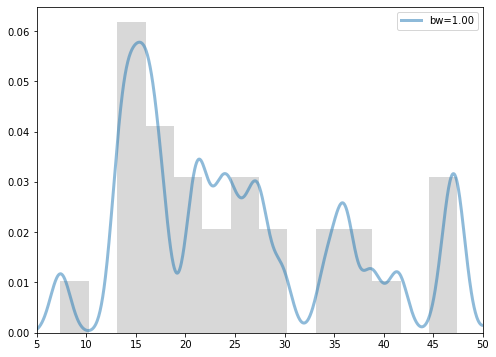

In [7]:
x_grid = np.linspace(5, 50, 1000)
x = prom_TT

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper right')
ax.set_xlim(5, 50);

## Método de aceptación y rechazo

In [8]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    pdf = lambda x: np.exp(kde_skl.score_samples(x[:, np.newaxis]))
    return pdf

Máximo de f: 0.05712663185245824


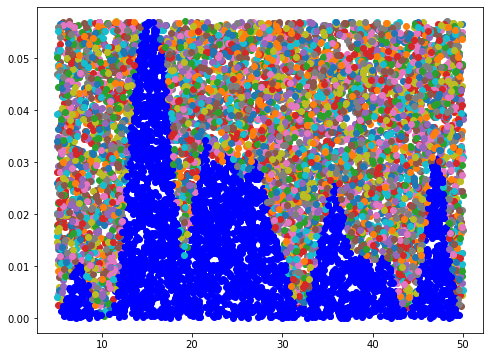

In [9]:
# Función objetivo 
x_grid = np.linspace(5, 50, 1000)
data1 = np.asarray(prom_TT)
f = kde_sklearn(data1, x_grid, bandwidth=1)
# Máximo de la función f
max_f = max(f(x))
# Función t
t = lambda x: max_f*np.ones(len(x))
x = np.arange(5,50,0.01)  # Rango donde se graficarán las funciones
print('Máximo de f:',max_f) 
# Gráficas de las funciones
plt.figure(figsize=(8,6))

# Validación del método
N = 10000 # número de puntos a simular
R2 = np.random.rand(N)
R1 = np.random.uniform(5,50,N)

Acep_rechazo(R2,R1,f,t);

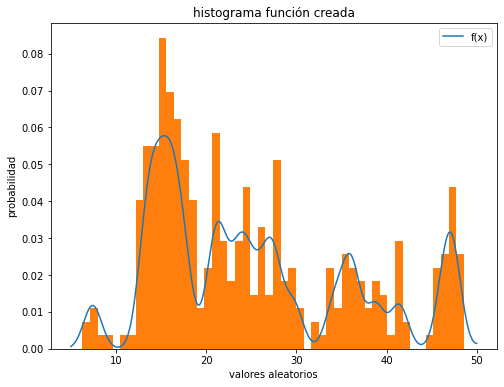

In [10]:
# Función objetivo 
f = kde_sklearn(data1, x_grid, bandwidth=1)
x = np.arange(5,50,0.01) # Rango donde se graficará las funciones

# Gráfica de la función
plt.figure(figsize=(8,6))
plt.plot(x,f(x),label='f(x)')
plt.legend()

t = lambda x: max_f*np.ones(len(x))
N = 1000
R2 = np.random.rand(N)
R1 = np.random.uniform(5,50,N)
histograma(R2, R1, f, t);

> El bandwidth óptimo a utilizar es 1.

## Ajuste de distribución

> A continuación probaremos distintas distribuciones de probabilidad para nuestros datos, y mediante el error y la prueba de Sminorv-Kolmogrov determinaremos cuál es la que mejor se ajusta a nuestros datos. 

/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.05.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.0333333333333332.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.0555555555555554.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.083333333333333.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns

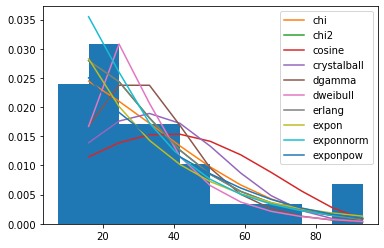

                    error
distribución             
chi2          1.26234e-05
erlang        1.26235e-05
dweibull      1.60028e-05
chi           1.63681e-05
dgamma        1.98768e-05
exponpow      2.26101e-05
exponnorm     2.36253e-05
expon         2.38261e-05
crystalball   3.65437e-05
cosine        6.16215e-05


In [11]:
distribucion(prom_TT, 10)

Las distribuciones de probabilidad que mejor se ajustan a nuestros datos, según sus menores errores resultantes son: 
- **CHI2** 
- **ERLANG**
- **DWEIBULL**

###  Prueba de Kolmogorov-Smirnov
    
    
La prueba KS es una prueba no paramétrica y sin distribución: no hace suposiciones sobre la distribución de datos. La prueba KS se puede utilizar para comparar una muestra con una distribución de probabilidad de referencia o para comparar dos muestras.
    
    
Suponga que tenemos observaciones `x1, x2,… xn` que creemos que provienen de una distribución P. La prueba KS se usa para evaluar:
    
- Hipótesis nula $H_0$: Las muestras provienen de P
- Alternative Hypothesis $H_a$: Las muestras no provienen de P

In [12]:
d_continuas = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]

results = []
for i in d_continuas[10:20]:
    dist = getattr(st, i)
    param = dist.fit(prom_TT)
    a = st.kstest(prom_TT, i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.05.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.0333333333333332.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.0555555555555554.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.083333333333333.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns

exponnorm: statistic=0.07754805074545085, pvalue=0.9768520720614916
chi2: statistic=0.10058338390866339, pvalue=0.8477946269292891
erlang: statistic=0.10058445956474452, pvalue=0.8477858587782457
chi: statistic=0.13502743909097387, pvalue=0.5212427311450929
dgamma: statistic=0.16224739340003747, pvalue=0.29899737186876774
expon: statistic=0.1789431239655385, pvalue=0.20059564560800924
crystalball: statistic=0.1809016289280192, pvalue=0.1909030074197794
dweibull: statistic=0.18208706109815825, pvalue=0.1852149741542236
exponpow: statistic=0.19259342027232712, pvalue=0.14040371739521074
cosine: statistic=0.24518326807863255, pvalue=0.027613345224882457


>Las distribuciones de probabilidad que mejor se ajustan a nuestros datos, según la prueba de Kolmogorov son: 
>- **EXPONNORM** 
>- **CHI2**
>- **ERLANG**

> Utilizaremos el método **Q-Q** para las mejores distribuciones de probabilidad para nuestro conjunto de datos.

### EXPONNORM

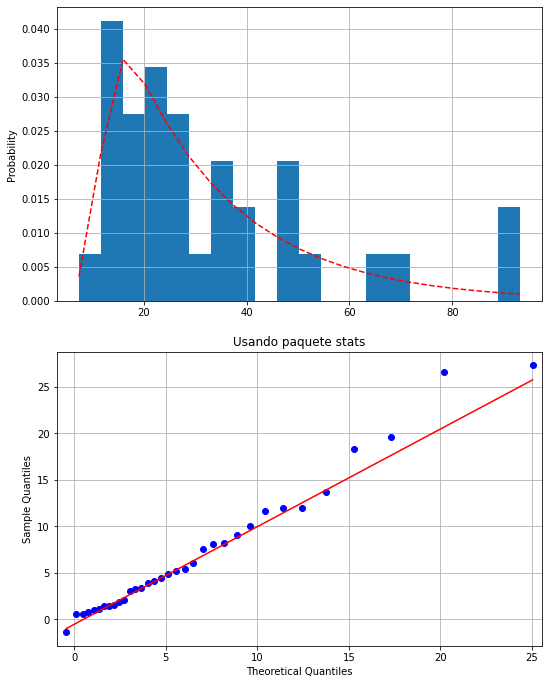

In [13]:
qq(prom_TT,"exponnorm")

### CHI2

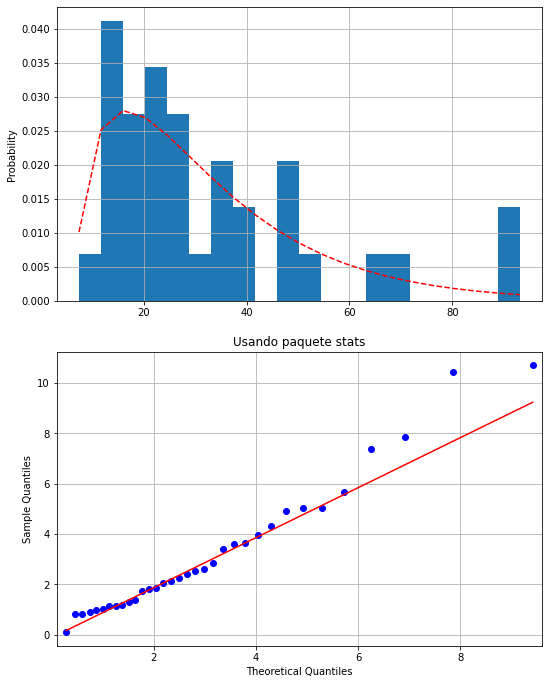

In [14]:
qq(prom_TT,"chi2")

### ERLANG

/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.05.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.0333333333333332.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.0555555555555554.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.083333333333333.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns

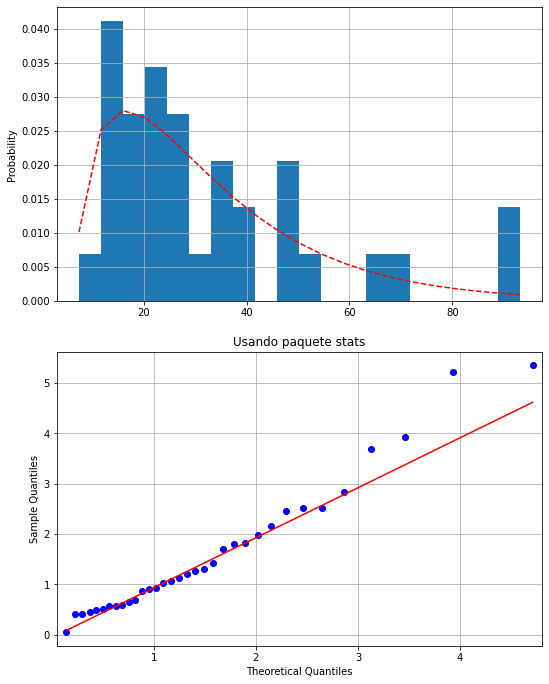

In [15]:
qq(prom_TT,"erlang")

> La distribución de probabilidad que mejor se ajusta a nuestros datos es **EXPONNORM**, en la cual podemos observar claramente que la cola derecha tiene un mayor peso que la izquierda.

## Parámetros

In [16]:
params = st.exponnorm.fit(prom_TT)

# Separate parts of parameters
arg = params[:-2]
loc1 = params[-2]
scale1 = params[-1]

c = arg[0]

print('c=',c,'loc=',loc1,'scale=',scale1)

c= 7.023487470396008 loc= 11.602853946231365 scale= 2.9831996055872665


## Intervalo de confianza

In [17]:
np.random.seed(55555)

N = 100
confianza = 0.95
X = st.exponnorm.rvs(c,loc1,scale1,N)
st.sem
i1 = st.t.interval(confianza,len(X)-1, loc=np.mean(X), scale=st.sem(X))
print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s' %(confianza,i1))
print('Media calculada' ,np.mean(X))

Con una confianza de 0.95 la media estará en el intervalo t,
 (28.228740151765763, 36.93245464517011)
Media calculada 32.58059739846794


## Prueba chi cuadrado - Histograma

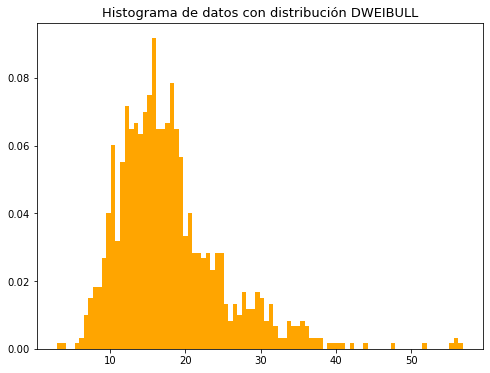

media mu =29.579547, desviación estándar muestral =15.576611


In [39]:
np.random.seed(555)
mu_real = prom_TT.mean()
sigma_real = prom_TT.std()
N = 100 # Cantidad de muestras
n1 = st.exponnorm.rvs(c,loc1,scale1, size=1000)
J = 90  # Cantidad de particiones del histograma
plt.figure(figsize=(8,6))
[freq, x, _] = plt.hist(n1, J, density=True,color='orange')
plt.title('Histograma de datos con distribución DWEIBULL',size=13)
plt.show()

# Se obvia el último valor de x para obtener exactamente J muestras de x
x = x[:-1] 

# Media y desviación estándar muestral
mu = np.mean(x)
sigma = np.std(x)
print('media mu =%f, desviación estándar muestral =%f'%(mu,sigma))

### Prueba de hipótesis
    
> $H_0$: la distribución es exponnorm.

> $H_a$: la distribución no es exponnorm.

In [19]:
pi = st.exponnorm.pdf(x, c,loc1,scale1)
# Cálculo de la esperanza usando la expresión teórica
Ei = x*pi
# Cálculo teórico de la chi cuadrada
x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, freq)))
print('Valor de chi cuadrado teorico  = ', x2)

# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(freq, Ei)
print('Valor de chi cuadrado librería = ', X2)

# Cálculo de Grados de libertad del estadístico
p = 2 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

Valor de chi cuadrado teorico  =  17.312493088437726
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=17.312493088437726, pvalue=1.0)
Estadístico de chi_cuadrado =  109.77330935028795
Media muestral =  83.81778883293745 
Desviación estándar muestral =  45.73076718722543


> No se rechaza la $H_0$ por lo tanto, los datos distribuyen exponnorm.

## Muestreo estratificado

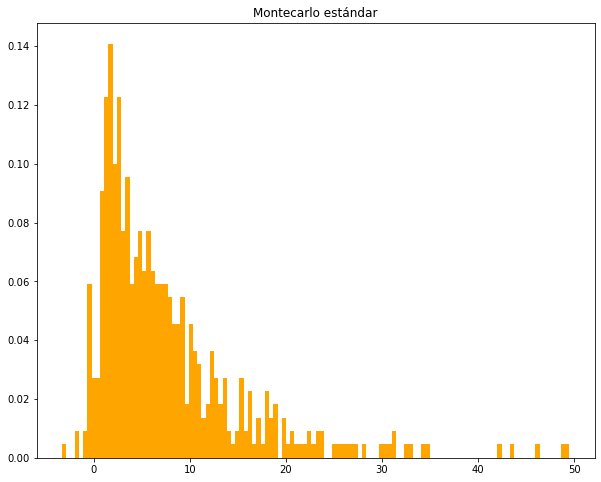

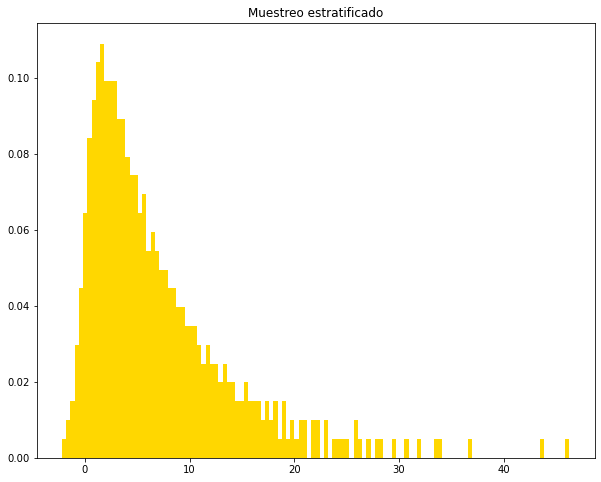

In [20]:
N = 500
# (Método transformada inversa visto en clases pasadas)
# Método montecarlo estándar 
montecarlo_standar = st.exponnorm.ppf(np.random.rand(N),c)
plt.figure(figsize=(10,8))
plt.hist(montecarlo_standar,120,density=True,color='orange')
plt.title('Montecarlo estándar')
plt.show()

# Método muestreo estratificado (B estratos)
B = N
U2 = np.random.rand(B)
i = np.arange(0,B)
v = (U2+i)/B
m_estratificado = st.exponnorm.ppf(v,c)

plt.figure(figsize=(10,8))
plt.hist(m_estratificado,120,density=True,color='gold')
plt.title('Muestreo estratificado')
plt.show()

> Gracias a los estratos generados, los datos y la distribución se observan mucho más claros y mejor distribuida.

## Conclusión

# Nodo 2. Tiempos frente al cliente

In [21]:
CT = data.groupby(['Categoría']).mean()
prom_CT2 = CT['Tiempo frente al cliente']
prom_CT2.head()

Categoría
APOYO VIA TELEFONICA     0.146677
AUDITORIA DE SERVICIO    1.349174
CALL CENTER              0.046383
CAMBIO DE UBICACION      0.962393
CM                       0.108180
Name: Tiempo frente al cliente, dtype: float64

In [22]:
x_grid = np.linspace(-2, 12, 1000)
x = prom_CT2

{'bandwidth': 0.02}


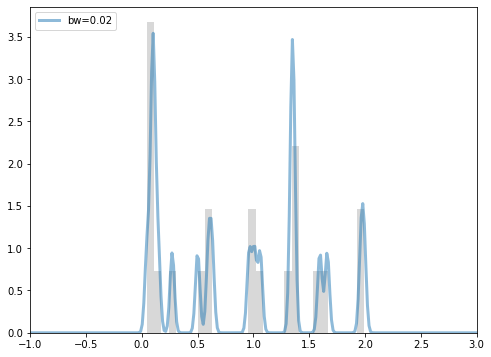

In [23]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.015, .02, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-1,3);

### Método de aceptación y rechazo 

In [24]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    pdf = lambda x: np.exp(kde_skl.score_samples(x[:, np.newaxis]))
    return pdf

Máximo de f: 3.5357941010751492


/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


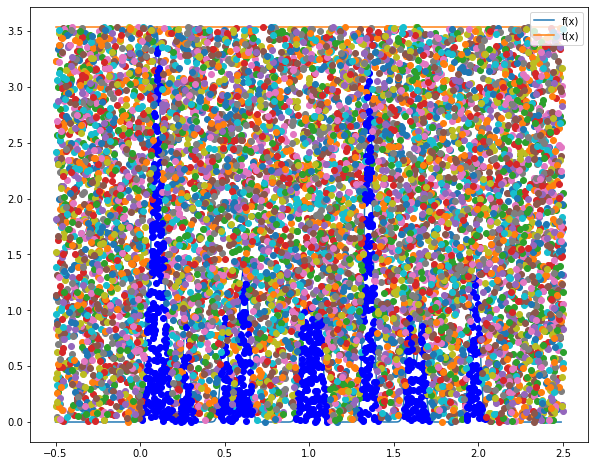

In [25]:
# Función objetivo 
data2 = np.asarray(prom_CT2)
f = kde_sklearn(data2, x_grid, bandwidth=0.02)
# Máximo de la función f
max_f = max(f(x))
# Función t
t = lambda x: max_f*np.ones(len(x))
x =  np.arange(-0.5,2.5,0.01)   # Rango donde se graficará las funciones
print('Máximo de f:',max_f)
# Gráficas de las funciones
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()

# Validación del método
N = 10000 # número de puntos a simular
R2 = np.random.rand(N)
R1 = np.random.uniform(-0.5,2.5,N)

Acep_rechazo(R2,R1,f,t)

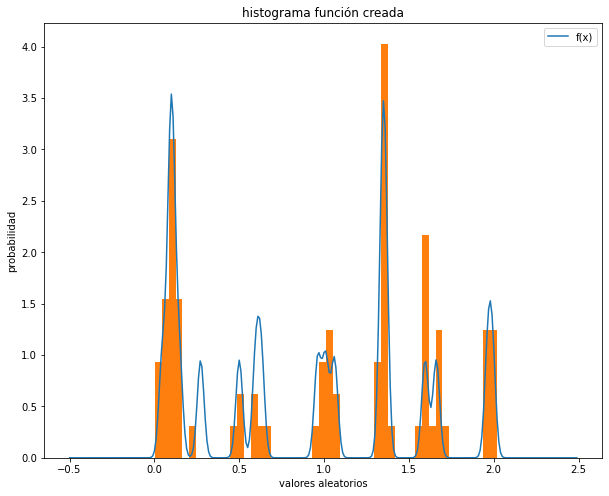

In [26]:
# Función objetivo 
f = kde_sklearn(data2, x_grid, bandwidth=0.02)
x =  np.arange(-0.5,2.5,0.01)  # Rango donde se graficará las funciones
# Gráfica de la función
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label='f(x)')
plt.legend()

t = lambda x: max_f*np.ones(len(x))
N = 1000
R2 = np.random.rand(N)
R1 = np.random.uniform(-0.5,2.5,N)
histograma(R2, R1, f, t)

> El bandwith óptimo a utilizar es 0.02

## Ajuste de distribución

/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 128.1.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 115.9.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 117.93333333333331.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 120.98333333333332.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: R

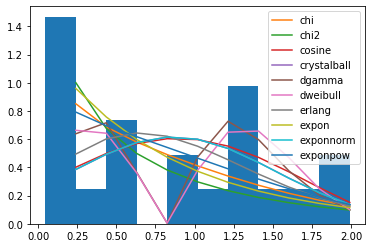

                 error
distribución          
dweibull      0.142871
chi2          0.144875
expon         0.149202
chi           0.149279
exponpow      0.155614
dgamma        0.159763
erlang        0.204648
cosine        0.208768
exponnorm     0.216101
crystalball   0.216149


In [27]:
distribucion(prom_CT2, 10)

Las distribuciones de probabilidad que mejor se ajustan a nuestros datos, según sus menores errores resultantes son: 
- **DWEIBULL**
- **CHI2**
- **EXPON**


In [28]:
d_continuas = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]

results = []
for i in d_continuas[10:20]:
    dist = getattr(st, i)
    param = dist.fit(prom_CT2)
    a = st.kstest(prom_CT2, i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 128.1.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 115.9.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 117.93333333333331.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 120.98333333333332.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: R

/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 22.70899047777438.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 21.088156484088827.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 23.52430511981239.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2958: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 22.368757328795276.
  warnings.warn(
/Users/alerico/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_cont

dweibull: statistic=0.12149655103953251, pvalue=0.8795377316926981
dgamma: statistic=0.13436559573863116, pvalue=0.7953924579436651
crystalball: statistic=0.1547505184672477, pvalue=0.6406074226893834
exponnorm: statistic=0.1547577881924977, pvalue=0.6405506868792415
cosine: statistic=0.16894533295879074, pvalue=0.5316216852969093
erlang: statistic=0.17026618649472725, pvalue=0.5217983355045706
chi: statistic=0.1855078024674669, pvalue=0.4147022534032516
exponpow: statistic=0.18563089521954013, pvalue=0.4138902589898835
expon: statistic=0.1955445409024038, pvalue=0.35159979309111855
chi2: statistic=0.24055104868687271, pvalue=0.14873933163832065


>Las distribuciones de probabilidad que mejor se ajustan a nuestros datos, según la prueba de Kolmogorov son: 
>- **DWEIBULL** 
>- **DGAMMA**
>- **CRYSTALBALL**

> Utilizaremos el método **Q-Q** para las mejores distribuciones de probabilidad para nuestro conjunto de datos.

### DWEIBULL

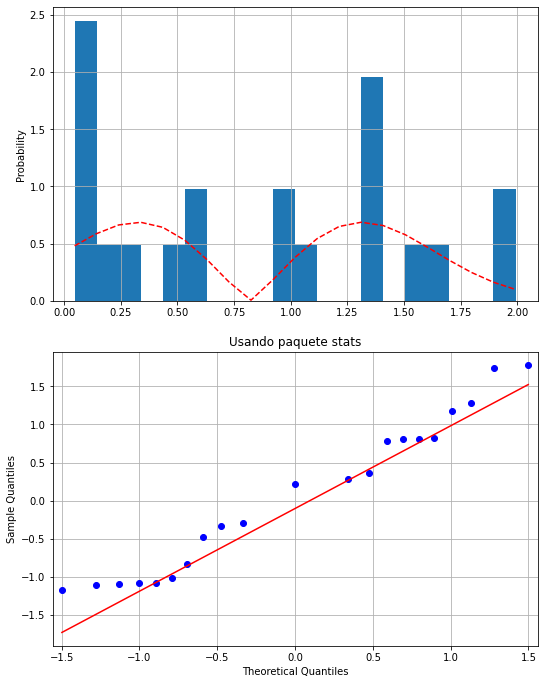

In [29]:
qq(prom_CT2,"dweibull")

### DGAMMA

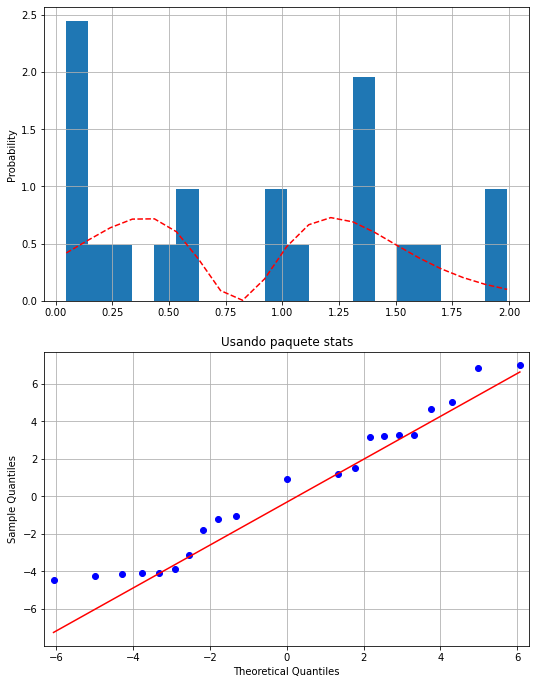

In [30]:
qq(prom_CT2,"dgamma")

### CRYSTALBALL

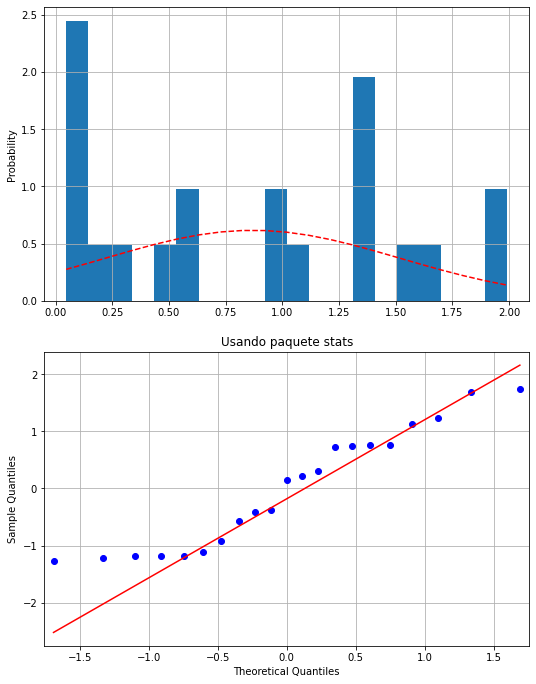

In [31]:
qq(prom_CT2,"crystalball")

> La distribución de probabilidad que mejor se ajusta a nuestros datos es **DWEIBULL** donde podemos ver que el punto de en medio es donde los datos son más ajustados y entre más alejados de esto (las colas) son más alejadas.

## Parámetros

In [32]:
params = st.dweibull.fit(prom_CT2)
# Separate parts of parameters
arg = params[:-2]
loc2 = params[-2]
scale2 = params[-1]

c = arg[0]

print('c=',c,'loc=',loc2,'scale=',scale2)

c= 2.1623208085265477 loc= 0.8196923047708111 scale= 0.6586773572088682


## Intervalo de confianza

In [33]:
np.random.seed(55555)
#media = 10; sd = 20
N = 100
confianza = 0.95
X = dweibull.rvs(c,loc2,scale2,N)
st.sem
i1 = st.t.interval(confianza,len(X)-1, loc=np.mean(X), scale=st.sem(X))
print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s' %(confianza,i1))
print('Media calculada' ,np.mean(X))

Con una confianza de 0.95 la media estará en el intervalo t,
 (0.7018508784903912, 0.9521947304894043)
Media calculada 0.8270228044898977


## Prueba chi cuadrada - Histograma

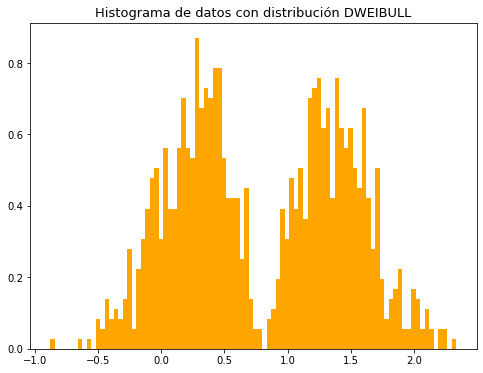

media =0.711427, desviación estándar muestral =0.926053


In [34]:
np.random.seed(555)
mu_real = prom_CT2.mean()
sigma_real = prom_CT2.std()
N = 100 # Cantidad de muestras
n1 = st.dweibull.rvs(c,loc2,scale2, size=1000)
J = 90  # Cantidad de particiones del histograma
plt.figure(figsize=(8,6))
[freq, x, _] = plt.hist(n1, J, density=True,color='orange')
plt.title('Histograma de datos con distribución DWEIBULL',size=13)
plt.show()
# Se obvia el último valor de x para obtener exactamente J muestras de x
x = x[:-1] 

# Media y desviación estándar muestral
mu = np.mean(x)
sigma = np.std(x)
print('media =%f, desviación estándar muestral =%f'%(mu,sigma))

### Prueba de hipótesis
    
> $H_0$: la distribución es dweibull.

> $H_a$: los datos no se distribuyen dweibull.

In [35]:
pi = st.dweibull.pdf(x, c,loc2,scale2)
# Cálculo de la esperanza usando la expresión teórica
Ei = x*pi
# Cálculo teórico de la chi cuadrada
x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, freq)))
print('Valor de chi cuadrado teorico  = ', x2)

# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(freq, Ei)
print('Valor de chi cuadrado librería = ', X2)

# Cálculo de Grados de libertad del estadístico
p = 2 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

Valor de chi cuadrado teorico  =  18.394324939004058
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=18.394324939004058, pvalue=1.0)
Estadístico de chi_cuadrado =  109.77330935028795
Media muestral =  0.711426800586501 
Desviación estándar muestral =  0.9260530753797328


> No rechazamos $H_0$ por lo tanto, los datos distribuyen dweibull.

## Muestreo estratificado

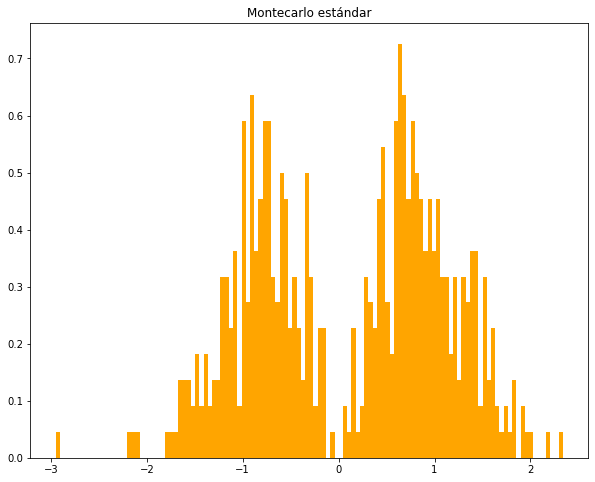

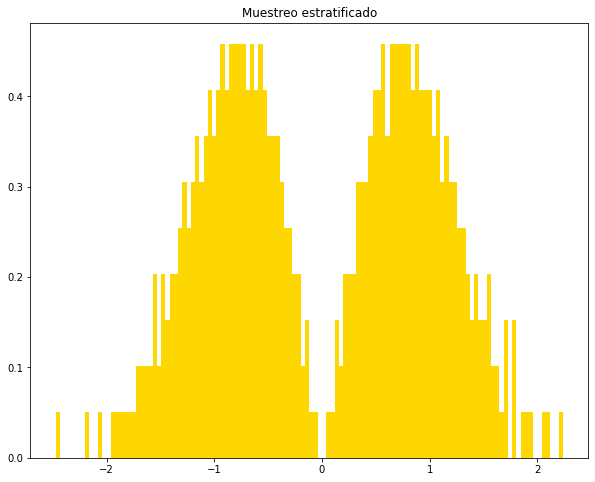

In [36]:
N = 500
# (Método transformada inversa visto en clases pasadas)
# Método montecarlo estándar 
montecarlo_standar = st.dweibull.ppf(np.random.rand(N),c)
plt.figure(figsize=(10,8))
plt.hist(montecarlo_standar,120,density=True,color='orange')
plt.title('Montecarlo estándar')
plt.show()

# Método muestreo estratificado (B estratos)
B = N
U2 = np.random.rand(B)
i = np.arange(0,B)
v = (U2+i)/B
m_estratificado = st.dweibull.ppf(v,c)

plt.figure(figsize=(10,8))
plt.hist(m_estratificado,120,density=True,color='gold')
plt.title('Muestreo estratificado')
plt.show()

> Los datos y la distribución se observan mucho más claros y mejor distribuidas.

## Conclusión

## Referencias